In [15]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'modules')
functionsdir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
sys.path.insert(0,functionsdir)
for includedir in [moduledir,functionsdir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *
from plot1DInvLog import *

## Input data dir
inputdir = os.path.join(os.path.dirname(workdir),'input')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats']
Own modules available: ['plot1DInvLog']


In [17]:
print("import some 2D variables")
file2D = os.path.join(inputdir,'fplane_n01_300_i03_256.2Dcom_1.nc')
varids2drop = ['SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'IntQN', 'IntQP', 'MSE', 'USFC', 'VSFC', 'W500', 'SWVP', 'TSFC', 'QSFC']
ds_2D = xr.open_dataset(file2D,decode_cf=False,drop_variables=varids2drop)

import some 2D variables


In [18]:
print("import some 3D variables")
file3D = os.path.join(inputdir,'fplane_n01_300_i03_256_0000864000.com3D.alltimes.nc')
varids2drop = ['p', 'U', 'V', 'TABS']
ds_3D = xr.open_dataset(file3D,decode_cf=False,drop_variables=varids2drop)

import some 3D variables


In [19]:
print("pick reference time")
dt_2D = np.diff(ds_2D.time)[0] # days
t_0 = 50 # days
i_t2D = int(t_0/dt_2D)
dt_3D = np.diff(ds_3D.time)[0] # days
i_t3D = int(t_0/dt_3D)

pick reference time


In [20]:
print("compute distribution of reference variable")
ref_varid = 'PW'
verbose = False
# Initialize
ref_dist_linear = Distribution(name=ref_varid)
# Compute
ref_dist_linear.computeDistribution(sample=ds_2D[ref_varid][i_t2D].values)
# Compute locations of reference bins
ref_dist_linear.storeSamplePoints(sample=ds_2D[ref_varid][i_t2D].values,verbose=verbose)

compute distribution of reference variable



In [21]:
print('check size')
ref_dist_linear.nlb, ref_dist_linear.nbins

check size


(50, 50)

In [22]:
print("compute conditional distribution for a 2D variable")
verbose = True
cond_varid_2D = 'Prec'
# Initialize
cond_dist_2D = ConditionalDistribution(name=cond_varid_2D,
                                       is3D=False,
                                       refDistribution=ref_dist_linear)
# Compute conditional distributions
cond_dist_2D.computeConditionalMeanAndVariance(sample=ds_2D[cond_varid_2D][i_t2D].values,
                                               verbose=False)


compute conditional distribution for a 2D variable


showing conditional distribution of 2D variable


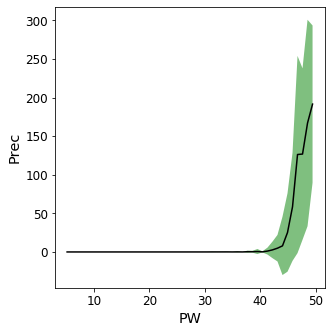


# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range



In [23]:
print("showing conditional distribution of 2D variable")
fig,ax = plt.subplots(figsize=(5,5))
# plot mean
ax.plot(cond_dist_2D.on.percentiles,cond_dist_2D.cond_mean,'k')
# plot 1-sigma standard error
x = cond_dist_2D.on.percentiles
y1 = cond_dist_2D.cond_mean - np.sqrt(cond_dist_2D.cond_var)
y2 = cond_dist_2D.cond_mean + np.sqrt(cond_dist_2D.cond_var)
ax.fill_between(x,y1,y2,where=y2>=y1,facecolor='g',alpha=0.5,interpolate=True)

ax.set_xlabel(ref_varid)
ax.set_ylabel(cond_varid_2D)

plt.show()
print("""
# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range
""")

In [24]:
ds_3D

<xarray.Dataset>
Dimensions:  (time: 100, x: 256, y: 256, z: 53)
Coordinates:
  * x        (x) float32 0.0 4000.0 8000.0 ... 1012000.0 1016000.0 1020000.0
  * y        (y) float32 0.0 4000.0 8000.0 ... 1012000.0 1016000.0 1020000.0
  * z        (z) float32 37.5 118.59 212.84 322.3 ... 17348.28 17765.27 18194.28
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 ... 96.0 97.0 98.0 99.0 100.0
Data variables:
    W        (time, z, y, x) float32 ...
    QRAD     (time, z, y, x) float32 ...
    QV       (time, z, y, x) float32 ...
    QN       (time, z, y, x) float32 ...
    QP       (time, z, y, x) float32 ...
Attributes:
    history:                   Wed Nov 16 15:29:34 2016: ncrcat fplane_n01_30...
    nco_openmp_thread_number:  1

In [140]:
print("compute conditional distribution for a 3D variable")
# cond_varid_3D = 'W'
cond_varid_3D = 'QRAD'
# Initialize
cond_dist_3D = ConditionalDistribution(name=cond_varid_3D,
                                       is3D=True,
                                       refDistribution=ref_dist_linear)
# Compute conditional distributions
cond_dist_3D.computeConditionalMeanAndVariance(ds_3D[cond_varid_3D][i_t3D].values)


compute conditional distribution for a 3D variable


In [141]:
from scipy import interpolate

def subplotSmooth2D(ax,x,y,Z,fplot='contourf',xmin=None,xmax=None,nx=50,nlev=50,vmin=None,vmax=None,**kwargs):
    """
    Plot 2D contours (exact method is defined by fplot) with user-defined Z-range and x range.
    """
    
    # set levels
    levels = nlev
    if vmin is not None and vmax is not None:
        levels = np.linspace(vmin,vmax,nlev+1)
    
    # set new x plotting range and interpolate Z onto it
    x_new = x.copy()
    Z_new = Z.copy()
    if xmin is not None and xmax is not None:
        x_new = np.linspace(xmin,xmax,nx+1)
        f_interp = interpolate.interp2d(x,y,Z,kind='cubic')
        Z_new = f_interp(x_new,y)
    X,Y = np.meshgrid(x_new,y)
    
    # remove values outside xrange
    X_out = np.logical_or(X < np.min(x),X > np.max(x))
    Z_new[X_out] = np.nan
    
    # plot
    return getattr(ax,fplot)(X,Y,Z_new,levels=levels,**kwargs)

showing conditional distribution of 2D variable


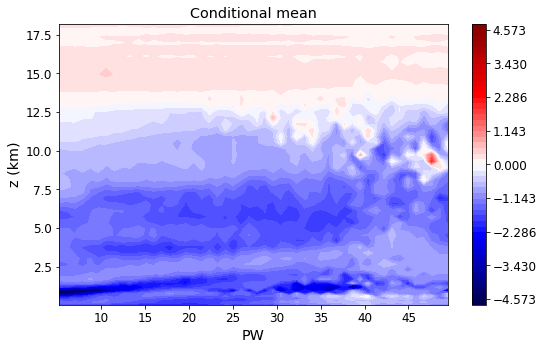

In [142]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
Z = cond_dist_3D.cond_mean
vmax = max(abs(np.max(Z)),abs(np.min(Z)))
vmin = -vmax

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
#                xmin=10,xmax=40,nx=100,\
               vmin=vmin,vmax=vmax,\
               cmap = plt.cm.seismic)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional mean')

plt.colorbar(h)

plt.show()

In [151]:
from matplotlib import colors

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

showing conditional distribution of 2D variable


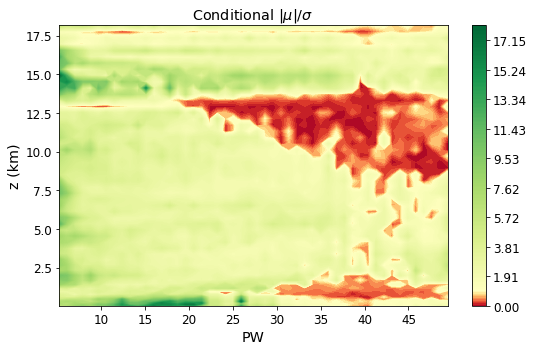

In [159]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
Z = np.absolute(cond_dist_3D.cond_mean)/cond_dist_3D.cond_std
vmax = max(abs(np.max(Z)),abs(np.min(Z)))
vmin = 0

norm = MidpointNormalize(midpoint=1,vmin=vmin,vmax=vmax)

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
#                xmin=10,xmax=40,nx=100,\
               vmin=vmin,vmax=vmax,nlev=200,\
               cmap = plt.cm.RdYlGn,\
               norm=norm)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional $|\mu|/\sigma$')

plt.colorbar(h)

plt.show()

In green where signal-to-noise is greater than 1, in red where it is below 1